In [1]:
import os
from dotenv import load_dotenv
import json
import pandas as pd
from openai import OpenAI
from datasets import load_dataset
from tqdm import tqdm
import time

load_dotenv()

# 定义所需的环境变量
REQUIRED_VARS = [
    "OPENROUTER_API_KEY",
    "OPENROUTER_BASE_URL",
]

# 使用字典推导式加载配置，同时检查缺失项
config = {var: os.environ.get(var) for var in REQUIRED_VARS}
missing_vars = [var for var, value in config.items() if not value]

if missing_vars:
    raise ValueError(f"错误: 缺少必要的环境变量: {', '.join(missing_vars)}")

config["MODEL_NAME"] = "google/gemini-2.5-flash"
config["LLM_TEMPERATURE"] = 0.1
config["DATASET_NAME"] = "hotpot_qa"
config["DATASET_CONFIG"] = "fullwiki"
config["DATASET_SPLIT"] = "validation"
config["NUM_SAMPLES"] = 30
config["OUTPUT_FILE"] = "experiment_1_hypothesis_quality.csv"

In [2]:
client = OpenAI(
    api_key=config["OPENROUTER_API_KEY"], 
    base_url=config["OPENROUTER_BASE_URL"]
    )

In [3]:
# --- Prompt 模板 ---
# 这是指导LLM生成假设图谱的核心指令
PROMPT_TEMPLATE = """
你是一个知识图谱构建专家。请根据以下问题，仅利用你的内部知识，生成一个回答该问题所需要的“假设性知识图谱”。
这个图谱应该能逻辑清晰地推导出问题的答案。

图谱应以JSON格式的三元组（主体, 关系, 客体）的列表形式输出。请确保图谱中的实体和关系能构成一个连贯的推理路径。

问题: "{question}"

请直接输出JSON格式的列表，不要包含其他任何解释或Markdown标记。
"""

In [4]:
# --- 辅助函数 ---
def parse_llm_output(raw_output: str) -> list:
    """
    尝试解析LLM返回的字符串，提取出三元组列表。
    这个函数会处理一些常见的问题，比如代码块标记。
    """
    if not raw_output:
        return []
    
    # 移除Markdown的JSON代码块标记
    if raw_output.strip().startswith("```json"):
        raw_output = raw_output.strip()[7:-3].strip()
    
    try:
        # 尝试解析JSON
        parsed_json = json.loads(raw_output)
        if isinstance(parsed_json, list):
            return parsed_json
        else:
            return []
    except json.JSONDecodeError:
        # 如果解析失败，返回空列表
        print(f"\n[警告] JSON解析失败，原始输出: {raw_output}")
        return []

def get_hypothesis_graph(question: str) -> tuple[str, list]:
    """
    调用OpenAI API为给定的问题生成假设图谱。
    返回原始输出和解析后的三元组列表。
    """
    prompt = PROMPT_TEMPLATE.format(question=question)
    
    try:
        response = client.chat.completions.create(
            model=config["MODEL_NAME"],
            messages=[
                {"role": "system", "content": "你是一个严谨的知识图谱专家，并且总是以JSON格式输出。"},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1,  # 使用较低的温度以获得更确定的输出
            max_tokens=500,
            response_format={"type": "json_object"} # 强制模型输出JSON
        )
        raw_output = response.choices[0].message.content
        
        # 即使强制JSON，有时也需要解析其内部结构
        # 假设模型返回的JSON对象有一个 'graph' 键
        try:
            data = json.loads(raw_output)
            parsed_triples = data.get("triples", []) # 假设键名为'triples'，可根据需要调整
        except (json.JSONDecodeError, AttributeError):
             # 如果顶级解析失败或内容不是字典，尝试原始解析
             parsed_triples = parse_llm_output(raw_output)

        return raw_output, parsed_triples
    
    except Exception as e:
        print(f"\n[错误] 调用OpenAI API时发生错误: {e}")
        return f"API_ERROR: {e}", []

# --- 主逻辑 ---
def main():
    """
    主函数，执行整个实验流程。
    """
    print(f"正在从Hugging Face加载数据集: {config["DATASET_NAME"]} ({config["DATASET_CONFIG"]})...")
    # 加载数据集
    dataset = load_dataset(config["DATASET_NAME"], config["DATASET_CONFIG"], split=config["DATASET_SPLIT"])
    
    # 选取一小部分样本
    sample_dataset = dataset.select(range(config["NUM_SAMPLES"]))
    
    results = []

    print(f"\n开始为 {config['NUM_SAMPLES']} 个问题生成假设图谱...")
    # 使用tqdm显示进度条
    for sample in tqdm(sample_dataset, desc="处理问题中"):
        question_id = sample['id']
        question_text = sample['question']
        question_level = sample['level']
        
        # 调用API获取结果
        raw_output, parsed_triples = get_hypothesis_graph(question_text)
        
        # 将结果存储起来
        results.append({
            'id': question_id,
            'question': question_text,
            'level': question_level,
            'llm_raw_output': raw_output,
            'parsed_triples': parsed_triples,
            # --- 以下为人工评估列，预留为空 ---
            'structural_plausibility (0/1)': '',
            'key_entity_recall (0/1)': '',
            'path_relevance (0/1)': '',
            'notes': ''
        })
        
        # 防止触发API的速率限制
        time.sleep(1) 

    # 将结果转换为Pandas DataFrame
    df = pd.DataFrame(results)
    
    # 保存到CSV文件
    df.to_csv(config["OUTPUT_FILE"], index=False, encoding='utf-8-sig')
    
    print(f"\n实验完成！结果已保存到: {config['OUTPUT_FILE']}")
    print("\n下一步：请打开CSV文件，并手动填写 'structural_plausibility', 'key_entity_recall', 'path_relevance' 和 'notes' 列。")

In [5]:
main()

正在从Hugging Face加载数据集: hotpot_qa (fullwiki)...

开始为 30 个问题生成假设图谱...


处理问题中: 100%|██████████| 30/30 [01:08<00:00,  2.28s/it]


实验完成！结果已保存到: experiment_1_hypothesis_quality.csv

下一步：请打开CSV文件，并手动填写 'structural_plausibility', 'key_entity_recall', 'path_relevance' 和 'notes' 列。


In [6]:
INPUT_FILE = "experiment_1_hypothesis_quality.csv"
OUTPUT_FILE = "experiment_1_auto_evaluated.csv"
EVALUATOR_MODEL_NAME = "google/gemini-2.5-pro"

EVALUATOR_PROMPT_TEMPLATE = """
You are a meticulous and impartial AI research assistant. Your task is to evaluate the quality of a 'hypothesis knowledge graph' generated by another AI model in response to a given question. Please assess the graph based on the three criteria below and provide your reasoning.

**Input:**
1.  **Original Question:** "{question}"
2.  **Hypothesis Graph to Evaluate:** {triples}

**Evaluation Criteria:**
1.  **Structural Plausibility (0 or 1):** Is the hypothesis graph a structurally valid, readable list of (subject, predicate, object) triples? If it's empty, malformed, or not a list of lists/tuples, score it 0. Otherwise, score it 1.
2.  **Key Entity Recall (0 or 1):** First, identify the key entities or concepts essential for answering the original question. Then, check if the majority of these key entities are present in the hypothesis graph. If yes, score 1. If critical entities are missing, score 0.
3.  **Path Relevance (0 or 1):** Does the sequence of triples form a logical and relevant reasoning path that could potentially lead to the answer? The individual facts in the path can be wrong, but the overall *approach* or *plan* must make sense. If the logic is sound, score 1. If the path is nonsensical, irrelevant, or circular, score 0.

**Your Output:**
You MUST respond in a valid JSON format. Do not add any text before or after the JSON object. The JSON object should have the following keys:
- "structural_plausibility": Your score (0 or 1).
- "key_entity_recall": Your score (0 or 1).
- "path_relevance": Your score (0 or 1).
- "notes": A brief, one-sentence explanation of your reasoning, especially explaining why you gave a score of 0, if applicable.

Example Response Format:
{{
  "structural_plausibility": 1,
  "key_entity_recall": 0,
  "path_relevance": 1,
  "notes": "The reasoning path is logical, but it missed the key entity 'Arthur's Magazine', which is critical for the answer."
}}
"""

In [7]:
def evaluate_graph(question: str, triples_str: str) -> dict:
    """
    Calls the evaluator LLM to assess a given hypothesis graph.
    """
    # Defensive check for empty or invalid triples string
    if not triples_str or triples_str == '[]':
        return {
            "structural_plausibility": 0,
            "key_entity_recall": 0,
            "path_relevance": 0,
            "notes": "Input graph was empty."
        }
        
    prompt = EVALUATOR_PROMPT_TEMPLATE.format(question=question, triples=triples_str)
    
    try:
        response = client.chat.completions.create(
            model=EVALUATOR_MODEL_NAME,
            messages=[
                {"role": "system", "content": "You are an AI quality evaluator that only responds in JSON format."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0, # Evaluation should be deterministic
            response_format={"type": "json_object"}
        )
        
        evaluation_result = json.loads(response.choices[0].message.content)
        return evaluation_result
        
    except Exception as e:
        print(f"\n[Error] API call or JSON parsing failed: {e}")
        return {
            "structural_plausibility": 0,
            "key_entity_recall": 0,
            "path_relevance": 0,
            "notes": f"Evaluation failed due to an error: {e}"
        }

In [8]:
def main():
    """
    Main function to load data, run evaluation, and save results.
    """
    try:
        df = pd.read_csv(INPUT_FILE)
    except FileNotFoundError:
        print(f"[Error] Input file not found: {INPUT_FILE}")
        print("Please run the first script (run_experiment_1.py) to generate this file.")
        return

    # Prepare columns for evaluation results
    for col in ['structural_plausibility (0/1)', 'key_entity_recall (0/1)', 'path_relevance (0/1)', 'notes']:
        # Use the auto-evaluated column names to avoid confusion
        df[f"auto_{col.split(' ')[0]}"] = None

    print(f"Starting automated evaluation of {len(df)} samples...")
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Evaluating samples"):
        question = row['question']
        # The 'parsed_triples' column is stored as a string in the CSV,
        # so we need to pass it as a string to the prompt.
        triples_str = row['parsed_triples']
        
        # Get evaluation from the LLM
        evaluation = evaluate_graph(question, triples_str)
        
        # Update DataFrame with the results from the evaluator
        df.loc[index, 'auto_structural_plausibility'] = evaluation.get('structural_plausibility')
        df.loc[index, 'auto_key_entity_recall'] = evaluation.get('key_entity_recall')
        df.loc[index, 'auto_path_relevance'] = evaluation.get('path_relevance')
        df.loc[index, 'auto_notes'] = evaluation.get('notes')

        time.sleep(1) # Be kind to the API

    # Remove original empty evaluation columns for clarity
    original_eval_cols = ['structural_plausibility (0/1)', 'key_entity_recall (0/1)', 'path_relevance (0/1)', 'notes']
    df_final = df.drop(columns=original_eval_cols)
    
    df_final.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
    
    print(f"\nAutomated evaluation complete. Results saved to {OUTPUT_FILE}")
    
    # --- Print Summary Statistics ---
    print("\n--- Feasibility Study Summary (Automated Evaluation) ---")
    try:
        # Convert columns to numeric, coercing errors to NaN
        plausibility_score = pd.to_numeric(df_final['auto_structural_plausibility'], errors='coerce').mean()
        recall_score = pd.to_numeric(df_final['auto_key_entity_recall'], errors='coerce').mean()
        relevance_score = pd.to_numeric(df_final['auto_path_relevance'], errors='coerce').mean()

        print(f"Structural Plausibility Success Rate: {plausibility_score:.2%}")
        print(f"Key Entity Recall Success Rate:       {recall_score:.2%}")
        print(f"Path Relevance Success Rate:          {relevance_score:.2%}")
        
        print("\nSuccess Criteria Check:")
        if plausibility_score > 0.95 and recall_score > 0.70 and relevance_score > 0.70:
            print("✅ The core assumption of generating high-quality hypotheses appears to be VALID.")
        else:
            print("⚠️ The core assumption of generating high-quality hypotheses may be WEAK. Review the 'auto_notes' column in the output CSV for common failure points.")
    except Exception as e:
        print(f"Could not compute summary statistics. Error: {e}")

In [9]:
main()

Starting automated evaluation of 30 samples...


Evaluating samples: 100%|██████████| 30/30 [05:03<00:00, 10.13s/it]


Automated evaluation complete. Results saved to experiment_1_auto_evaluated.csv

--- Feasibility Study Summary (Automated Evaluation) ---
Structural Plausibility Success Rate: 96.67%
Key Entity Recall Success Rate:       100.00%
Path Relevance Success Rate:          100.00%

Success Criteria Check:
✅ The core assumption of generating high-quality hypotheses appears to be VALID.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Configuration ---
INPUT_FILE = "experiment_1_auto_evaluated.csv"
OUTPUT_CHART_OVERALL = "figure_1_overall_success_rates.png"
OUTPUT_CHART_BY_DIFFICULTY = "figure_2_performance_by_difficulty.png"

# --- Plotting Style ---
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore', category=UserWarning) # Ignore a common Seaborn warning

In [11]:
def analyze_and_visualize(filepath: str):
    """
    Loads the evaluated data, calculates statistics,
    and generates visualizations.
    """
    # 1. Load and Prepare Data
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"[Error] Input file not found: {filepath}")
        print("Please ensure the auto-evaluation script has been run successfully.")
        return

    # Convert evaluation columns to numeric, coercing errors to NaN
    eval_cols = ['auto_structural_plausibility', 'auto_key_entity_recall', 'auto_path_relevance']
    for col in eval_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Drop rows where evaluation was not possible
    df.dropna(subset=eval_cols, inplace=True)
    df[eval_cols] = df[eval_cols].astype(int)

    if df.empty:
        print("[Error] No valid data to analyze after cleaning. Please check the CSV file.")
        return

    # 2. Calculate Overall Success Rates
    overall_scores = {
        'Structural Plausibility': df['auto_structural_plausibility'].mean(),
        'Key Entity Recall': df['auto_key_entity_recall'].mean(),
        'Path Relevance': df['auto_path_relevance'].mean()
    }
    
    # --- Plot 1: Overall Success Rates ---
    plt.figure(figsize=(10, 6))
    overall_df = pd.DataFrame(list(overall_scores.items()), columns=['Metric', 'Success Rate'])
    
    barplot = sns.barplot(x='Metric', y='Success Rate', data=overall_df, palette="viridis")
    
    # Add percentage labels on top of bars
    for p in barplot.patches:
        barplot.annotate(f"{p.get_height():.1%}", 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

    plt.title('Overall Success Rates of Hypothesis Generation', fontsize=16)
    plt.ylabel('Success Rate', fontsize=12)
    plt.xlabel('')
    plt.ylim(0, 1.05) # Set y-axis limit to 105%
    plt.tight_layout()
    plt.savefig(OUTPUT_CHART_OVERALL)
    print(f"Saved overall success rate chart to: {OUTPUT_CHART_OVERALL}")
    # plt.show() # Uncomment to display plot directly

    # --- Plot 2: Performance by Difficulty ---
    # We focus on the two more challenging metrics: Recall and Relevance
    difficulty_df = df.groupby('level')[['auto_key_entity_recall', 'auto_path_relevance']].mean().reset_index()
    difficulty_df_melted = difficulty_df.melt(id_vars='level', var_name='Metric', value_name='Success Rate')
    
    # Clean up metric names for legend
    difficulty_df_melted['Metric'] = difficulty_df_melted['Metric'].map({
        'auto_key_entity_recall': 'Key Entity Recall',
        'auto_path_relevance': 'Path Relevance'
    })
    
    plt.figure(figsize=(12, 7))
    grouped_barplot = sns.barplot(x='level', y='Success Rate', hue='Metric', data=difficulty_df_melted, 
                                  order=['easy', 'medium', 'hard'], palette="mako")
                                  
    plt.title('Performance by Question Difficulty', fontsize=16)
    plt.ylabel('Success Rate', fontsize=12)
    plt.xlabel('Difficulty Level', fontsize=12)
    plt.ylim(0, 1.05)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.savefig(OUTPUT_CHART_BY_DIFFICULTY)
    print(f"Saved performance-by-difficulty chart to: {OUTPUT_CHART_BY_DIFFICULTY}")
    # plt.show() # Uncomment to display plot directly

    # --- Print Summary for Conclusion ---
    print("\n--- Quantitative Summary for Conclusion ---")
    for metric, score in overall_scores.items():
        print(f"{metric}: {score:.2%}")

    # --- Qualitative Analysis: Show Common Failure Reasons ---
    print("\n--- Qualitative Analysis: Common Failure Notes (Top 5) ---")
    failure_df = df[(df['auto_key_entity_recall'] == 0) | (df['auto_path_relevance'] == 0)]
    if not failure_df.empty:
        # Display up to 5 examples of failure notes
        for i, row in failure_df.head(5).iterrows():
            print(f"- Q: {row['question'][:80]}...")
            print(f"  Note: {row['auto_notes']}\n")
    else:
        print("No significant failures detected in the sample.")

/tmp/ipykernel_2587/603094274.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Metric', y='Success Rate', data=overall_df, palette="viridis")


Saved overall success rate chart to: figure_1_overall_success_rates.png
Saved performance-by-difficulty chart to: figure_2_performance_by_difficulty.png

--- Quantitative Summary for Conclusion ---
Structural Plausibility: 96.67%
Key Entity Recall: 100.00%
Path Relevance: 100.00%

--- Qualitative Analysis: Common Failure Notes (Top 5) ---
No significant failures detected in the sample.


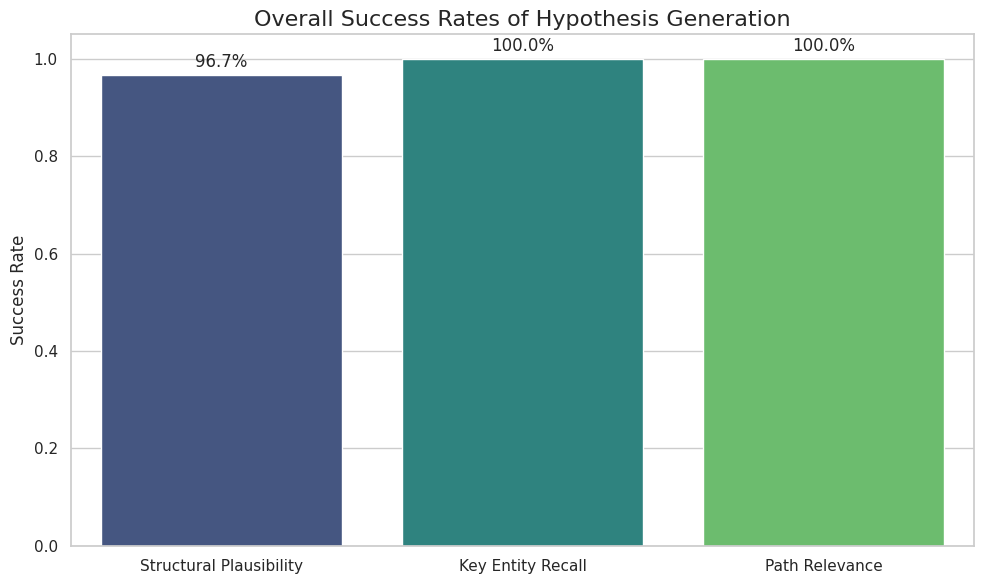

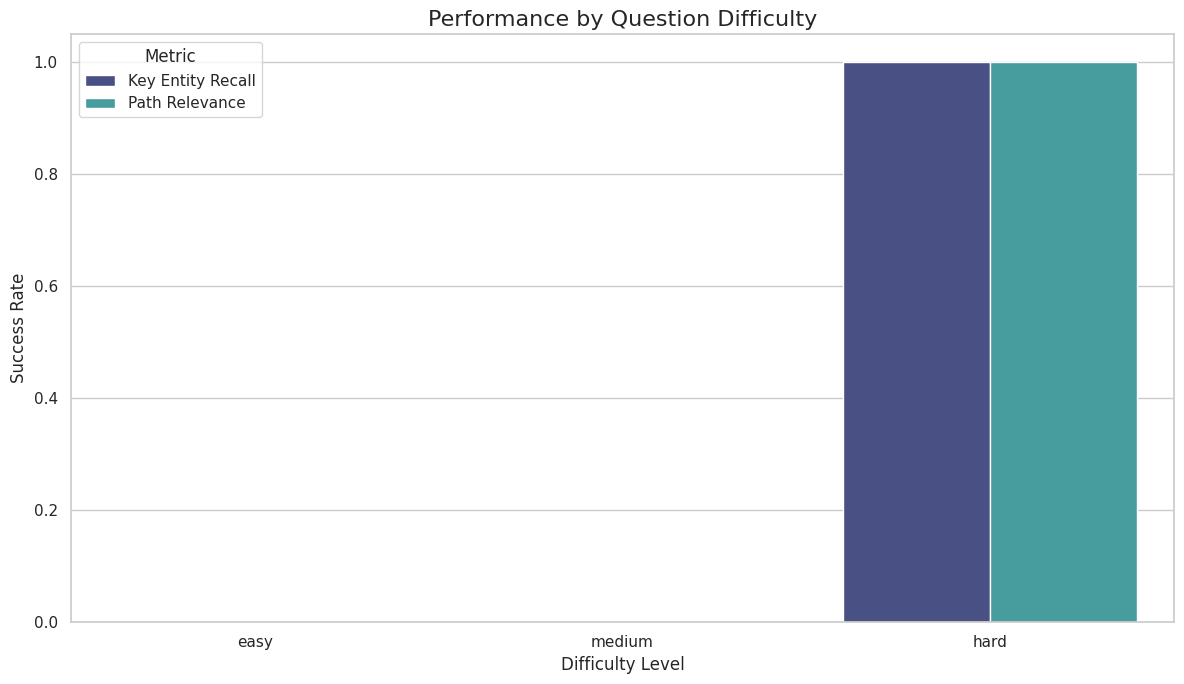

In [12]:
analyze_and_visualize(INPUT_FILE)